In [473]:
import pandas as pd
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [474]:
nee_data = pd.read_csv('./smapSatelite/nee_mean.csv',header=None)
rh_data = pd.read_csv('./smapSatelite/rh_mean.csv',header=None)
gpp_data = pd.read_csv('./smapSatelite/gpp_mean.csv',header=None)
modis = pd.read_csv('./DadosNPPSatelite/filtered_scaled_Npp_500m.csv',header=None)

In [475]:
def dateindex(df):
    df[0] = df[0].str.extract(r'(?:[^_]*_){4}(.*?)(?=T)')
    df = df.drop([1,2,3,4],axis=1)
    df.index = df[0].apply(lambda x: datetime.strptime(x,"%Y%m%d"))
    df = df.drop(0,axis=1)
    return df
rh_data = dateindex(rh_data)
nee_data = dateindex(nee_data)
gpp_data = dateindex(gpp_data)
gpp_data

,5,6,7,8,9,10,11,12,13
0,,,,,,,,,
2015-03-31,5.189993,6.025257,7.225599,4.954659,5.681196,6.554158,5.136171,5.348177,6.291223
2015-04-01,4.752002,5.353181,6.122799,4.560592,5.031677,5.470536,4.773900,4.739937,5.187224
2015-04-02,6.090189,6.323827,6.792858,6.003588,6.113571,6.266069,6.455631,5.928704,6.145502
2015-04-03,9.775927,10.648981,11.685995,9.492579,10.185151,10.694510,10.068659,9.773981,10.382153
2015-04-04,9.285623,10.167361,11.316257,8.980276,9.679028,10.305090,9.507604,9.261170,9.964371
...,...,...,...,...,...,...,...,...,...
2023-07-27,10.427434,10.411612,10.397974,10.385464,10.388522,9.268710,10.420069,9.904121,8.734727
2023-07-28,9.549095,9.456480,8.547644,9.557837,9.647991,8.352782,10.175252,9.339059,6.936022
2023-07-29,9.372083,9.292155,8.522319,9.325547,9.429492,8.263597,9.898705,9.110124,6.835155


In [476]:
def modis_npp(modis_data):
    
    modis_data = modis_data.drop([0,1,3,4],axis=1).reset_index().drop('index',axis=1) # Retirando colunas com informações não relevantes e restabelecendo o dataframe a partir de um index 0 nas 2 linhas
    
    modis_data.columns = range(len(modis_data.columns.to_list())) # Reiniciando o index a partir do 0 para as colunas 
    
    modis_data[0] = modis_data[0].apply(lambda x:x[1:5])
    
    modis_data.set_index(0,inplace=True) # Colocando o "Acquisition Date [ A (YYYYDDD) ]"  como index para legibilidade do dataframe
    
    modis_npp_mean = modis_data.mean(axis=1) # Média de NPP nesses anos 
    
    return modis_npp_mean

modis_npp_mean = modis_npp(modis)

In [477]:
modis_2015_2022 = modis_npp_mean['2015':'2022']
nee_data = nee_data.resample('Y').mean()
rh_data = rh_data.resample('Y').mean()
gpp_data = gpp_data.resample('Y').mean()

In [478]:
nee_mean = nee_data[9]
rh_mean = rh_data[9]
npp_calculado = (nee_mean + rh_mean)
npp_calculado = npp_calculado[:'2022']

In [479]:
gpp_data = gpp_data[9]
npp_calculado2 = (gpp_data - rh_mean)
npp_calculado2 = npp_calculado2[:'2022']

In [480]:
df = pd.DataFrame(index=pd.date_range(start='2015-01-01', end='2022-12-31', freq='A-DEC'))
df['NPP Calculado (NEE + RH)'] = npp_calculado.values
df['MODIS'] = modis_2015_2022.values
df['NPP Calculado (GPP - RH)'] = npp_calculado2.values

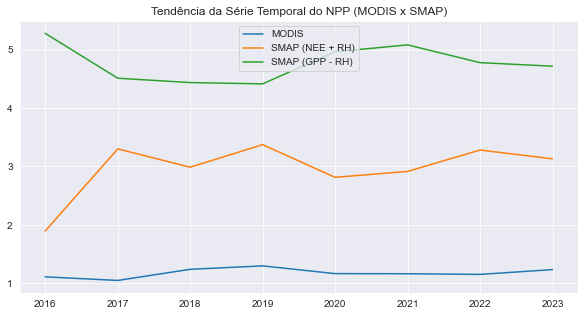

In [481]:
npp_calculado_decomponsicao = seasonal_decompose(df['NPP Calculado (NEE + RH)'])
modis_2015_2022_decomponsicao = seasonal_decompose(df['MODIS'])
npp_calculado2_decomponsicao = seasonal_decompose(df['NPP Calculado (GPP - RH)'])
plt.figure(figsize=(10,5))
plt.plot(modis_2015_2022_decomponsicao.trend)
plt.plot(npp_calculado_decomponsicao.trend)
plt.plot(npp_calculado2_decomponsicao.trend)
plt.title("Tendência da Série Temporal do NPP (MODIS x SMAP)")
plt.legend(['MODIS','SMAP (NEE + RH)','SMAP (GPP - RH)'],loc='upper center').set_visible(True)

In [482]:
# FUNÇÃO CRIADA PARA CRIAÇÃO DOS GRÁFICOS
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
def reg_graph (x, y, data,sct_size=None,s=10,title='', legend_visibility=True, legend_title='', xlabel='', ylabel='', fit_intercept=True, ativar_grafico_yx=False,reg_from_start=False, offset_txt_x=0.15,offset_txt_y=2.25):
    # x = eixo x do gráfico
    # y = eixo y do gráfico
    # data = dataframe origem dos dados que representam x e y
    # sct_size = tamanho do scatter no gráfico BASEADO em uma coluna do dataframe
    # s = tamanho do scatter no gráfico BASEADO em um NUMERO
    # title = título do gráfico
    # legend_visibility = visibilidade da legenda
    # legend_title = título da legenda
    # xlabel = título do eixo x
    # ylabel = titulo do eixo y
    # offset_txt_x = deslocamento do texto da função no eixo x
    # offset_txt_y = deslocamento do texto da função no eixo y

    sns.set_style('darkgrid')

    f, ax = plt.subplots(1,figsize=(8, 5))

    sns.scatterplot(x=data[x], y=data[y], data=data,size=sct_size,s=s)

    rng = np.random.default_rng(1234) #seed para valores aleatórios
    lr = LinearRegression(fit_intercept=fit_intercept)
    fitted_reg = lr.fit(data[[x]],data[[y]])

    if not fit_intercept:
        fitted_reg.intercept_ = [fitted_reg.intercept_] # Prevenindo erros

    r2_score = fitted_reg.score(data[[x]],data[[y]]) # R² Score
    x_reg_line = rng.uniform(data[x].min(), data[x].max(), size=100) # gerando valores entre os valores do scatterplot para criar a reta
    y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0] # função y=ax + b para representar a reta criada

    if reg_from_start:

        if (data[x].min() < 0) and (abs(data[x].min()) > data[y].max()): # Para valores data[x] negativos

            x_reg_line = rng.uniform(data[x].min() * 2 , 0.0, size=10000) # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0

        elif (data[y].min() < 0) and (abs(data[y].min()) > data[x].max()): # Para valores data[y] negativos

            x_reg_line = rng.uniform(data[y].min() * 2 , 0.0, size=10000) # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0

        elif (data[x].max() > data[y].max()):

            x_reg_line = rng.uniform(0.0, data[x].max() * 2, size=10000)

        else:

            x_reg_line = rng.uniform(0.0, data[y].max() * 2, size=10000)

        y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0] # função y=ax + b para representar a reta criada


    text_coord_x = data[x].max() - data[x].max() * offset_txt_x  #eixo x do texto


    plt.text(text_coord_x, offset_txt_y, f'Y={round(fitted_reg.coef_[0][0],4)}x + {round(fitted_reg.intercept_[0],4)}',fontsize=12, ha='center', va='center',color='blue') #Texto da reta Azul
    plt.text(text_coord_x, offset_txt_y - (offset_txt_y*0.3), f'R²:{round(r2_score,4)}', fontsize=12, ha='center', va='center',color='blue') # Texto r²


    ax.set_ylim((0, (data[y].max() + (data[y].max()/2)))) # tamanho limite do plot no eixo y
    ax.set_xlim((0, data[x].max() + data[x].max()/2)) # tamanho limite do plot no eixo x
    ax.plot(x_reg_line,y_reg_line[0]) #reta de regressão

    if ativar_grafico_yx:
        y_x = rng.uniform(0, 1000, size=1000) # gerando 100 valores aleatórios
        ax.plot(y_x,y_x, 'k--') # reta y=x

    if legend_title:
        plt.legend(title=legend_title,loc='upper left').set_visible(legend_visibility) #legenda no canto superior esquerdo

    plt.title(title) # Título do gráfico
    plt.xlabel(xlabel) #Título do eixo X
    plt.ylabel(ylabel) #Título do eixo y
    plt.tight_layout() #Redimensionar melhor o gráfico
    plt.show() #Mostrar o gráfico

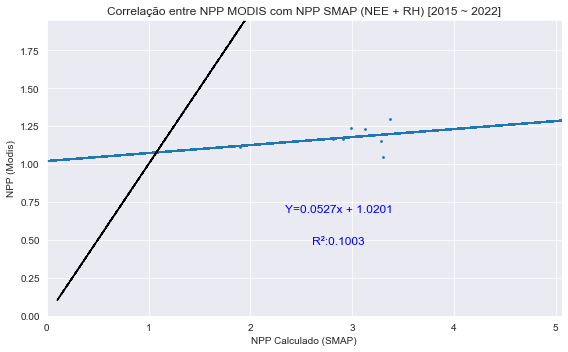

In [483]:
#(x, y, data,sct_size=10, title='', legend_visibility=True, legend_title=None, xlabel='', ylabel='', fit_intercept=True, ativar_grafico_yx=False,reg_from_start=False, offset_txt_x=0.15,offset_txt_y=2.25)
reg_graph(data=df,x='NPP Calculado (NEE + RH)',y='MODIS',title='Correlação entre NPP MODIS com NPP SMAP (NEE + RH) [2015 ~ 2022]',legend_title=False,xlabel='NPP Calculado (SMAP)', ylabel='NPP (Modis)',ativar_grafico_yx=True,reg_from_start=True,offset_txt_y=0.7)

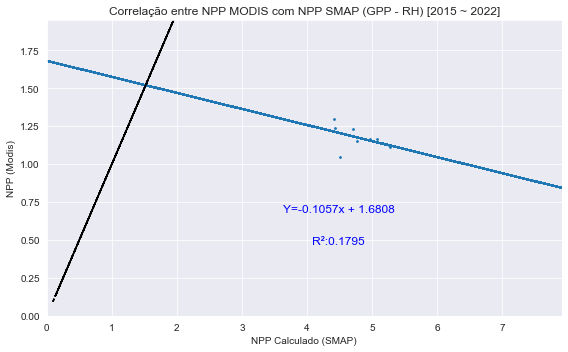

In [484]:
reg_graph(data=df,x='NPP Calculado (GPP - RH)',y='MODIS',title='Correlação entre NPP MODIS com NPP SMAP (GPP - RH) [2015 ~ 2022]',legend_title=False,xlabel='NPP Calculado (SMAP)', ylabel='NPP (Modis)',ativar_grafico_yx=True,reg_from_start=True,offset_txt_y=0.7)

<AxesSubplot:>

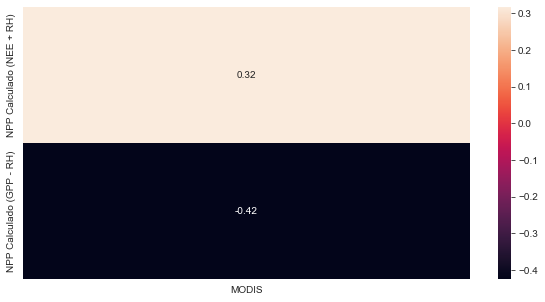

In [485]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr()['MODIS'][::2].to_frame(),annot=True)